In [2]:
import numpy as np
import pandas as pd
import os

import re
from ast import literal_eval
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.7M Feb 12 11:01 data/Byvsij_SSSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  21M Feb 12 10:59 data/Ekonomika.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  14M Feb 12 10:59 data/Mir.csv.bz2


In [4]:
name_dataset = 'Ekonomika'

### load data

In [5]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(71835, 4)
CPU times: user 7.39 s, sys: 86.5 ms, total: 7.48 s
Wall time: 7.48 s


In [6]:
df.head()

,date,topic,text,predict
0,2008-02-11 08:04:00,"""Экономика""","['рост', 'ввп', 'россия', 'составить', 'журнал...",Экономика
1,2008-02-11 08:43:00,"""Экономика""","['цена', 'нефть', 'вырастить', 'заявление', 'в...",Экономика
2,2008-02-11 09:34:00,"""Экономика""","['microsoft', 'corp', 'получение', 'официальны...",Экономика
3,2008-02-11 17:29:00,"""Экономика""","['официальный', 'газпром', 'ртс', 'gazp', 'сер...",Экономика
4,2008-02-11 17:35:00,"""Экономика""","['россия', 'официально', 'вступить', 'ряд', 'с...",Экономика


* parse data

In [7]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head()

,date,topic,text,predict,year,month
0,2008-02-11 08:04:00,"""Экономика""","['рост', 'ввп', 'россия', 'составить', 'журнал...",Экономика,2008,2
1,2008-02-11 08:43:00,"""Экономика""","['цена', 'нефть', 'вырастить', 'заявление', 'в...",Экономика,2008,2
2,2008-02-11 09:34:00,"""Экономика""","['microsoft', 'corp', 'получение', 'официальны...",Экономика,2008,2
3,2008-02-11 17:29:00,"""Экономика""","['официальный', 'газпром', 'ртс', 'gazp', 'сер...",Экономика,2008,2
4,2008-02-11 17:35:00,"""Экономика""","['россия', 'официально', 'вступить', 'ряд', 'с...",Экономика,2008,2


In [8]:
df.year.value_counts()

2015    10031
2014     8731
2009     7965
2016     7902
2013     7101
2018     7011
2008     6152
2017     5579
2010     5094
2011     3184
2012     2804
2019      281
Name: year, dtype: int64

In [9]:
df.month.value_counts()

10    6855
9     6829
12    6764
3     6314
4     6083
6     6069
11    5989
7     5830
8     5547
2     5468
1     5275
5     4812
Name: month, dtype: int64

In [10]:
df.text = df.text.apply(lambda x: literal_eval(x))

### preprocess if text with lemma

In [11]:
df['text_join'] = df.text.apply(lambda x: ' '.join(x))
df.head()

,date,topic,text,predict,year,month,text_join
0,2008-02-11 08:04:00,"""Экономика""","[рост, ввп, россия, составить, журналист, токи...",Экономика,2008,2,рост ввп россия составить журналист токио вице...
1,2008-02-11 08:43:00,"""Экономика""","[цена, нефть, вырастить, заявление, венесуэла,...",Экономика,2008,2,цена нефть вырастить заявление венесуэла уго ч...
2,2008-02-11 09:34:00,"""Экономика""","[microsoft, corp, получение, официальный, отка...",Экономика,2008,2,microsoft corp получение официальный отказ сов...
3,2008-02-11 17:29:00,"""Экономика""","[официальный, газпром, ртс, gazp, сергей, купр...",Экономика,2008,2,официальный газпром ртс gazp сергей куприянов ...
4,2008-02-11 17:35:00,"""Экономика""","[россия, официально, вступить, ряд, странучаст...",Экономика,2008,2,россия официально вступить ряд странучастница ...


* cleanedNames

In [12]:
from cleanedNames import KeyProc
cn = KeyProc()

In [13]:
%%time
df.text_join = df.text_join.apply(cn.replaceKeywords)

CPU times: user 1min 59s, sys: 2.98 ms, total: 1min 59s
Wall time: 1min 59s


In [14]:
df.text = df.text_join.apply(lambda x: x.split(' ')) 
df.head()

,date,topic,text,predict,year,month,text_join
0,2008-02-11 08:04:00,"""Экономика""","[рост, ввп, россия, составить, журналист, токи...",Экономика,2008,2,рост ввп россия составить журналист токио вице...
1,2008-02-11 08:43:00,"""Экономика""","[цена, нефть, вырастить, заявление, венесуэла,...",Экономика,2008,2,цена нефть вырастить заявление венесуэла уго_ч...
2,2008-02-11 09:34:00,"""Экономика""","[microsoft, corp, получение, официальный, отка...",Экономика,2008,2,microsoft corp получение официальный отказ сов...
3,2008-02-11 17:29:00,"""Экономика""","[официальный, газпром, ртс, gazp, сергей_купри...",Экономика,2008,2,официальный газпром ртс gazp сергей_куприянов ...
4,2008-02-11 17:35:00,"""Экономика""","[россия, официально, вступить, ряд, странучаст...",Экономика,2008,2,россия официально вступить ряд странучастница ...


* add docID

In [15]:
df['docID'] = list(range(df.shape[0]))

In [16]:
df.rename(columns={'text':'lemmatized_text'},inplace=True)

In [17]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[рост, ввп, россия, составить, журналист, токи..."
1,1,2008,2,"[цена, нефть, вырастить, заявление, венесуэла,..."


In [18]:
print(df.shape)
df.isnull().sum()

(71835, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [19]:
df.year.min(),df.year.max()

(2008, 2019)

### preprocess if text full

* get dates

In [ ]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

* clean text

In [ ]:
import preprocessing_tools as pr

In [ ]:
%%time
df.text = df.text.apply(pr.clean_text)

In [ ]:
df.head(2)

* cleanedNames

In [ ]:
from cleanedNames import KeyProc
cn = KeyProc()

In [ ]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

* lemmatization

In [ ]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

* add docID

In [ ]:
df['docID'] = list(range(df.shape[0]))

In [ ]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

In [ ]:
print(df.shape)
df.isnull().sum()

In [ ]:
df.year.min()

## model

* prepare

In [20]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 874 ms, sys: 116 ms, total: 991 ms
Wall time: 989 ms


In [21]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [22]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/Ekonomika", num_batches=72)
CPU times: user 33.5 s, sys: 680 ms, total: 34.2 s
Wall time: 4.97 s


In [23]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [24]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=edb8a72b-b5d2-4395-b174-ff10fb60c810, num_entries=24511)

In [25]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 6
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

In [ ]:
#model_list

In [ ]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [ ]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

In [ ]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

In [ ]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [ ]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

In [ ]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

In [ ]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [ ]:
perplexity

### select the best model

In [ ]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

In [ ]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

---

In [26]:
select_topics = 20

In [27]:
num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')


	SparsityThetaScore: 0.711678147315979
	SparsityPhiScore: 0.8649687767028809
	PerplexityScore: 2129.4921875


In [28]:
best_model = model.clone()
best_model.num_topics

20

---

### print top words for each topics

In [29]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['валюта' 'валютный' 'рейтинг' 'политика' 'минфин' 'дефицит' 'облигация'
 'национальный' 'резервный' 'риска']
topic_1: ['акционер' 'втб' 'русало' 'пакет' 'сбербанк' 'иск' 'председатель' 'оао'
 'владеть' 'принадлежать']
topic_2: ['инфляция' 'ввп' 'темп' 'потребительский' 'доход' 'выражение'
 'минэкономразвития' 'население' 'расход' 'прогнозировать']
topic_3: ['деятельность' 'требование' 'кредитный' 'операция' 'лицензия'
 'информация' 'страхование' 'банковский' 'лицо' 'вклад']
topic_4: ['кредит' 'банковский' 'кредитный' 'триллион' 'долг' 'сбербанк'
 'кредитование' 'резерв' 'задолженность' 'вэб']
topic_5: ['украина' 'пенсионный' 'газа' 'пенсия' 'украинский' 'газпром' 'газ'
 'кубометр' 'тариф' 'возраст']
topic_6: ['добыча' 'опека' 'запас' 'нефтяной' 'иран' 'бс' 'саудовский' 'сутки'
 'аравия' 'brent']
topic_7: ['очень' 'деньга' 'нужно' 'хороший' 'поэтому' 'сделать' 'подчеркнуть'
 'делать' 'политика' 'некоторый']
topic_8: ['авиакомпания' 'оператор' 'аэрофлот' 'аэропорт' 'самолёт' 'б

### get topics-docs matrix

shape theta: (20, 71835)


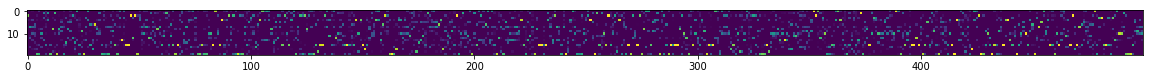

In [30]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [31]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
57000,0.105601,0.401553,0.000000,0.066375,0.000000,0.000000,0.000000,0.089234,0.0,0.055152,0.204529,0.010388,0.000000,0.0,0.067169,0.0,0.000000,0.000000,0.000000,0.000000
57001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.528805,0.419321,0.0,0.000000,0.000000,0.000000,0.041042,0.0,0.000000,0.0,0.000000,0.010831,0.000000,0.000000
57002,0.106637,0.129317,0.000000,0.039544,0.049098,0.000000,0.021154,0.000000,0.0,0.000000,0.347670,0.000000,0.000000,0.0,0.014885,0.0,0.114126,0.116072,0.061498,0.000000
57003,0.000000,0.000000,0.033587,0.000000,0.000000,0.022105,0.081168,0.099327,0.0,0.000000,0.305686,0.341462,0.000000,0.0,0.000000,0.0,0.000000,0.116666,0.000000,0.000000
57004,0.000000,0.000000,0.000000,0.000000,0.000000,0.016114,0.000000,0.000000,0.0,0.000000,0.288354,0.492330,0.036336,0.0,0.000000,0.0,0.026140,0.000000,0.000000,0.140727


## DataViz

In [32]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,2008,2,0.540338,0.000000,0.405610,0.0,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.054052
1,1,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.198026,...,0.00000,0.309838,0.054787,0.000000,0.000000,0.293571,0.000000,0.0,0.0,0.000000
2,2,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,3,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.740551,0.000000,...,0.00000,0.085549,0.000000,0.000000,0.104286,0.069613,0.000000,0.0,0.0,0.000000
4,4,2008,2,0.070750,0.005085,0.008405,0.0,0.087334,0.015678,0.200349,...,0.07143,0.145964,0.000000,0.023157,0.016422,0.000000,0.006991,0.0,0.0,0.000000


In [33]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (132, 20)


topic_0    topic_1    topic_2    topic_3    topic_4    topic_5  \
year month                                                                     
2008 2       4.813261   5.488080   5.964662   4.208624   3.089160  11.228310   
     3      17.044489  20.835608  15.005271  12.134480  14.875734  29.550312   
     4       9.700424  28.329887  19.131075  13.660434  13.452602  11.601107   
     5       6.115730  19.806046  28.161425  10.916204   5.899732  13.090446   
     6      12.787965  36.243973  27.930038  18.576984   9.928675  10.474600   

             topic_6    topic_7    topic_8   topic_9   topic_10   topic_11  \
year month                                                                   
2008 2      2.959507   8.912588   4.829643  2.878154   9.171441   8.536683   
     3      4.789611  24.783245  19.599918  7.777667  31.505749  15.863841   
     4      6.058620  20.146597  26.414236  9.657586  33.146400  22.246500   
     5      8.020043  19.506926   7.868697  6.411815  27.148411  13.207221   
     6      7.483702  25.953140  10.207395  6.762856  40.962597  18.512325   

             topic_12   topic_13   topic_14   topic_15   topic_16   topic_17  \
year month                                                                     
2008 2       5.467681   7.261091   5.182634  10.614285   2.754752   1.217703   
     3      12.473089  16.681610  16.623259  22.803558  12.965866  10.445355   
     4      12.647904  16.886654  14.686558  12.763766   9.758890   9.757644   
     5      15.514112  17.972965  16.951159  22.593479   7.955207   6.677433   
     6      19.105944  27.368671  20.552599  12.795038  10.087998   8.387285   

            topic_18   topic_19  
year month                       
2008 2      2.464272   7.957469  
     3      8.848382  18.392958  
     4      8.569420   7.383693  
     5      3.825008   5.357947  
     6      6.782107   7.096110

### straightforward matrix heatmap

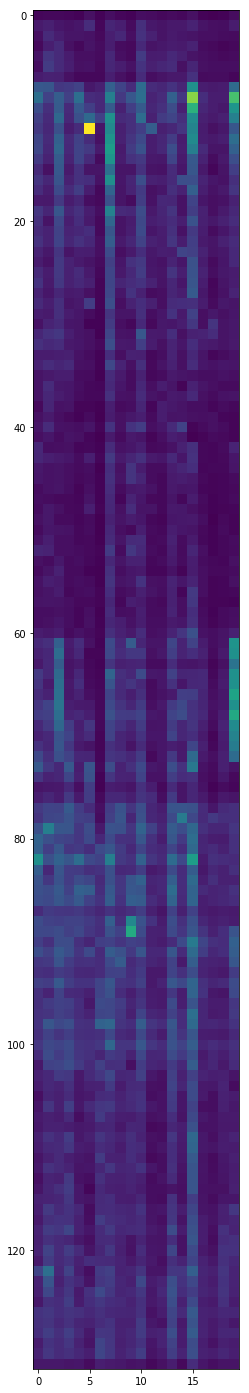

In [48]:
plt.figure(figsize=(5, 25))
plt.imshow(gb[topics])

## pygal

In [35]:
import pygal
from IPython.display import SVG, HTML

In [36]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [37]:
max(gb['topic_1'].values)

100.12274

In [38]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [39]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [40]:
import joypy # !pip install joypy

In [41]:
print(joined.shape)
joined.head()

(71835, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,2008,2,0.540338,0.000000,0.405610,0.0,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.054052
1,1,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.198026,...,0.00000,0.309838,0.054787,0.000000,0.000000,0.293571,0.000000,0.0,0.0,0.000000
2,2,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,3,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.740551,0.000000,...,0.00000,0.085549,0.000000,0.000000,0.104286,0.069613,0.000000,0.0,0.0,0.000000
4,4,2008,2,0.070750,0.005085,0.008405,0.0,0.087334,0.015678,0.200349,...,0.07143,0.145964,0.000000,0.023157,0.016422,0.000000,0.006991,0.0,0.0,0.000000


In [42]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,date
0,0,2008,2,0.540338,0.000000,0.405610,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.054052,2008-02-01
1,1,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.198026,...,0.309838,0.054787,0.000000,0.000000,0.293571,0.000000,0.0,0.0,0.000000,2008-02-01
2,2,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2008-02-01
3,3,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.740551,0.000000,...,0.085549,0.000000,0.000000,0.104286,0.069613,0.000000,0.0,0.0,0.000000,2008-02-01
4,4,2008,2,0.070750,0.005085,0.008405,0.0,0.087334,0.015678,0.200349,...,0.145964,0.000000,0.023157,0.016422,0.000000,0.006991,0.0,0.0,0.000000,2008-02-01


In [43]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd.head()

,date,topic,mentions
0,2008-02-01,topic_0,0.540338
4,2008-02-01,topic_0,0.070750
5,2008-02-01,topic_0,0.005738
7,2008-02-01,topic_0,0.184830
11,2008-02-01,topic_0,0.234825


In [44]:
dd2 = dd.groupby(['date','topic']).sum()
dd2.head()

mentions
date       topic             
2008-02-01 topic_0   4.813261
           topic_1   5.488080
           topic_10  9.171441
           topic_11  8.536683
           topic_12  5.467681

In [45]:
dd2=dd2.reset_index()
dd2.head()

,date,topic,mentions
0,2008-02-01,topic_0,4.813261
1,2008-02-01,topic_1,5.488080
2,2008-02-01,topic_10,9.171441
3,2008-02-01,topic_11,8.536683
4,2008-02-01,topic_12,5.467681


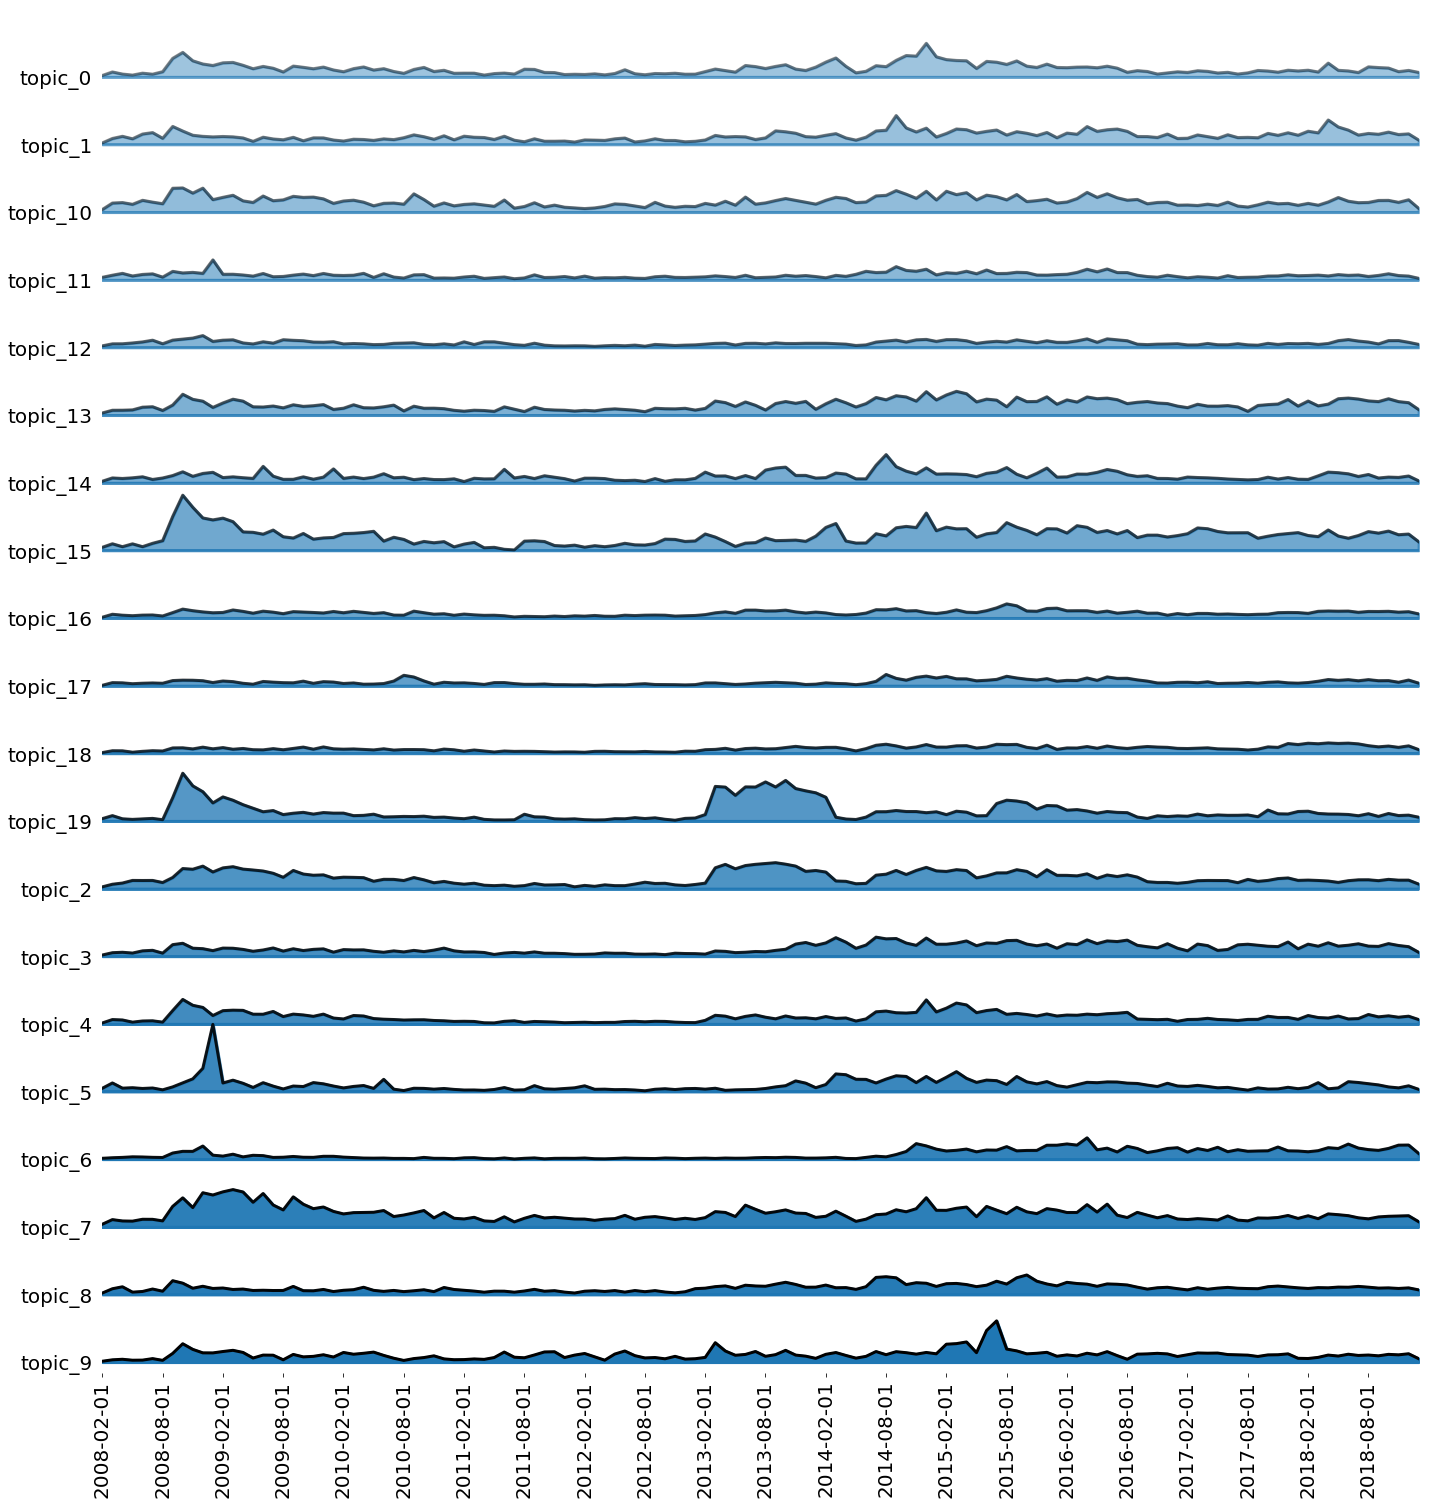

In [46]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [47]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")